Importing Essential Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Machine Learning Libraries (Part 1)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

print("Libraries imported successfully.")

Libraries imported successfully.


Loading datasets

In [6]:
# Load the Processed Data
print("Loading processed data...")

# 1. Load Training Data
train_df = pd.read_csv('processed_data/train_processed.csv', index_col=0)
# Split back into X and y
y_train = train_df['price']
X_train = train_df.drop(columns=['price'])

# 2. Load Internal Validation Data
val_df = pd.read_csv('processed_data/val_processed.csv', index_col=0)
# Split back into X and y
y_test = val_df['price']
X_test = val_df.drop(columns=['price'])

# 3. Load External Submission Data (No 'price' column here)
X_submission = pd.read_csv('processed_data/submission_processed.csv', index_col=0)

print(" Data Loaded Successfully.")
print(f"Training Set:   X={X_train.shape}, y={y_train.shape}")
print(f"Validation Set: X={X_test.shape},  y={y_test.shape}")
print(f"Submission Set: X={X_submission.shape}")

Loading processed data...
 Data Loaded Successfully.
Training Set:   X=(12967, 16), y=(12967,)
Validation Set: X=(3242, 16),  y=(3242,)
Submission Set: X=(5404, 20)


Training Random Forest Model (Part 1)

In [7]:
print("--- PART 1: TABULAR BASELINE (Random Forest) ---")

# 1. Initialize
rf_model = RandomForestRegressor(n_estimators=100,max_depth=None,bootstrap=True,oob_score=True,random_state=42)

# 2. Train
print("Training Random Forest...")
rf_model.fit(X_train, y_train)

# 3. Predict & Evaluate
y_pred_rf = rf_model.predict(X_test)

rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(" Random Forest Results:")
print("R² Score: ",rf_r2)
print("RMSE: ",rf_rmse)

--- PART 1: TABULAR BASELINE (Random Forest) ---
Training Random Forest...
 Random Forest Results:
R² Score:  0.8609411137147176
RMSE:  132099.60783401178


Block 1: Defines the MultimodalDataGenerator to handle image and tabular data loading ( Custom Data Generator Class)

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence

class MultimodalDataGenerator(Sequence):
    """
    Custom Data Generator for Hybrid AI.
    Loads data in batches (e.g., 32 at a time) to prevent RAM crashes.
    Inputs: 
        1. House Images (Satellite view)
        2. Tabular Data (Bedrooms, Sqft, etc.)
    Output:
        1. Price (Target)
    """
    def __init__(self, df, x_col, y_col, image_dir, batch_size=32, target_size=(224, 224), shuffle=True):
        self.df = df.copy()         # Work on a copy to avoid modifying original data
        self.x_col = x_col          # Column name for House ID (index)
        self.y_col = y_col          # Column name for Price (Target)
        self.image_dir = image_dir  # Path to 'house_images' folder
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        
        # Create a list of indices (0 to N) to track rows
        self.indices = np.arange(len(self.df))
        
        # Shuffle immediately upon starting
        self.on_epoch_end()

    def __len__(self):
        """Calculates the number of batches per epoch."""
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        """Generates one batch of data."""
        # 1. Select the indices for this batch (e.g., rows 0 to 32)
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        # 2. Find the House IDs for these rows
        batch_ids = [self.df.index[k] for k in indices]

        # 3. Generate data
        X, y = self.__data_generation(batch_ids, indices)
        return X, y

    def on_epoch_end(self):
        """Shuffles data after every epoch so the model doesn't memorize order."""
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_ids, batch_indices):
        """Loads the images and numbers for the specific batch."""
        
        # --- PART A: LOAD IMAGES ---
        images = []
        for house_id in batch_ids:
            img_path = os.path.join(self.image_dir, f"{house_id}.jpg")
            
            # Safety Check: If image didn't download, use a black placeholder
            if os.path.exists(img_path):
                try:
                    img = load_img(img_path, target_size=self.target_size)
                    img = img_to_array(img)
                    img = img / 255.0  # Normalize (0-255 -> 0-1)
                except:
                    # If image is corrupt
                    img = np.zeros((self.target_size[0], self.target_size[1], 3))
            else:
                # If image is missing
                img = np.zeros((self.target_size[0], self.target_size[1], 3))
            
            images.append(img)
        
        
        
    
       
        images = np.array(images, dtype=np.float32)
        
        if self.y_col and self.y_col in self.df.columns:
            tabular = self.df.iloc[batch_indices].drop(columns=[self.y_col]).values
        else:
            # This line is critical! It defines 'tabular' for prediction mode
            tabular = self.df.iloc[batch_indices].values
        
        tabular = np.array(tabular, dtype=np.float32)
        
        
        if self.y_col and self.y_col in self.df.columns:
            # Training Mode:  TUPLE 
            y = self.df.iloc[batch_indices][self.y_col].values
            return (images, tabular), y
        else:
            # Prediction Mode: A LIST 
            return [images, tabular]
        
        

        

Block 2:Sets up train_gen and val_gen with the correct batch size and image folders(Initialize Generators)

In [9]:
# --- BLOCK 2: INITIALIZE GENERATORS ---

# 1. Configuration
IMAGE_FOLDER = 'house_images'  # Must match the folder name where images are downloading
BATCH_SIZE = 32                # Process 32 houses at a time
IMAGE_SIZE = (224, 224)        # The standard size that AI models prefer

print("Preparing Data Generators...")

# 2. Re-combine X and y for the Generator
# The generator expects one single dataframe so it can shuffle X and y together securely.
train_full = pd.concat([X_train, y_train], axis=1)
val_full = pd.concat([X_test, y_test], axis=1)

# 3. Create the Training Generator
train_gen = MultimodalDataGenerator(
    df=train_full,
    x_col='id',       # Uses the Index (House ID) to find the image
    y_col='price',    # The target value we are predicting
    image_dir=IMAGE_FOLDER,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    shuffle=True      # True: Mixes up data so the model learns better
)

# 4. Create the Validation Generator
val_gen = MultimodalDataGenerator(
    df=val_full,
    x_col='id',
    y_col='price',
    image_dir=IMAGE_FOLDER,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    shuffle=False     # False: Keep order stable for accurate scoring
)

print(f" Generators Ready!")
print(f" - Training Batches per Epoch: {len(train_gen)}")
print(f" - Validation Batches per Epoch: {len(val_gen)}")

Preparing Data Generators...
 Generators Ready!
 - Training Batches per Epoch: 405
 - Validation Batches per Epoch: 101


Block 3:Constructs the model architecture using EfficientNetB0 for images and Dense layers for tabular data(Build Hybrid Neural Network)

In [10]:
# --- BLOCK 3: BUILD THE HYBRID MODEL ---
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_hybrid_model(tabular_shape):
    # --- BRANCH 1: IMAGE PROCESSING (The Visual Eye) ---
    # We use EfficientNetB0, pre-trained on ImageNet data
    # include_top=False means we cut off the final classification layer (we don't need to classify cats/dogs)
    print("Downloading EfficientNetB0 weights...")
    base_cnn = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the base model so we don't destroy its pre-learned patterns
    base_cnn.trainable = False
    
    # Input layer for images
    image_input = Input(shape=(224, 224, 3), name='image_input')
    
    # Pass images through the CNN
    x_img = base_cnn(image_input)
    x_img = GlobalAveragePooling2D()(x_img) # Condenses the image features into a vector
    
    # --- BRANCH 2: TABULAR PROCESSING (The Logical Eye) ---
    # Input layer for numbers (bedrooms, sqft, etc.)
    tabular_input = Input(shape=(tabular_shape,), name='tabular_input')
    
    # A simple neural network for the numbers
    x_tab = Dense(64, activation='relu')(tabular_input)
    x_tab = Dense(32, activation='relu')(x_tab)
    
    # --- COMBINE BOTH BRANCHES ---
    # Glue the Visual info and Logical info together
    combined = concatenate([x_img, x_tab])
    
    # --- FINAL PREDICTION LAYERS ---
    # The "Head" of the network that makes the decision
    x = Dense(128, activation='relu')(combined)
    x = Dropout(0.2)(x) # Dropout helps prevent overfitting
    x = Dense(64, activation='relu')(x)
    
    # Output Layer: 1 single number (The Price)
    # linear activation is standard for Regression
    output = Dense(1, activation='linear', name='price_output')(x)
    
    # Assemble the full model
    model = Model(inputs=[image_input, tabular_input], outputs=output)
    
    # Compile: We use Adam optimizer and Mean Squared Error (MSE) loss
    # Learning rate 0.001 is a safe starting point
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    
    return model

# Initialize the Model
# X_train.shape[1] automatically detects how many columns you have (bedrooms, sqft, etc.)
print("Building Model...")
hybrid_model = build_hybrid_model(tabular_shape=X_train.shape[1])

print("Model Architecture Built Successfully!")
hybrid_model.summary()

Building Model...
Model Architecture Built Successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ image_input[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      1,088 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1312)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    168,064 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_output        │ (None, 1)         │         65 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,229,124 (16.13 MB)

 Trainable params: 179,553 (701.38 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Block 4: Runs the training loop with Callbacks for Checkpointing, Early Stopping, and Learning Rate Reduction(Train the model)

In [11]:
# ----Block 4---- 
#The training loop

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

# --- Training Configuration ---

MODEL_FILENAME = 'best_hybrid_model.keras'

if os.path.exists(MODEL_FILENAME):
    # OPTION A: Load existing model (Saves time!, because again training it takes nearly 2 hrs of time)
    print(" Found saved model! Loading it now...")
    best_model = load_model(MODEL_FILENAME)
    print("Model loaded successfully. Ready for prediction.")

else:

    # 1. Checkpoint: Save the model only when validation accuracy improves
    checkpoint = ModelCheckpoint(
        filepath='best_hybrid_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # 2. Early Stopping: Halt training if validation loss stops improving (prevents overfitting)
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    # 3. Learning Rate Scheduler: Slow down learning rate if loss plateaus
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-5,
        verbose=1
    )

    # --- Execute Training ---
    print("Starting training process...")

    history = hybrid_model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=[checkpoint, early_stopping, reduce_lr],
        verbose=1
    )

    print("Training finished.")

 Found saved model! Loading it now...
Model loaded successfully. Ready for prediction.


Block 5: Plots the Training vs. Validation Loss to check for overfitting (Visualize Training History)

In [12]:
#------Block 5-----
# Visualization

def plot_training_history(history):
    """
    Plots the training and validation loss curves to evaluate model performance.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss, label='Training Loss (MSE)', linewidth=2)
    plt.plot(epochs, val_loss, label='Validation Loss (MSE)', linestyle='--', linewidth=2)
    
    plt.title('Hybrid Model Training Dynamics')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualize the results
if 'history' in locals():
    plot_training_history(history)

Block 6: Loads the best saved model, predicts on the validation set, calculates R², and plots the Actual vs. Predicted graph (Model Evaluation)

Loading best performing model...
Generating predictions on validation set...


c:\Users\navya\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 77s 729ms/step

--- FINAL HYBRID MODEL PERFORMANCE ---
R² Score: 0.8791
RMSE:     123,249.70


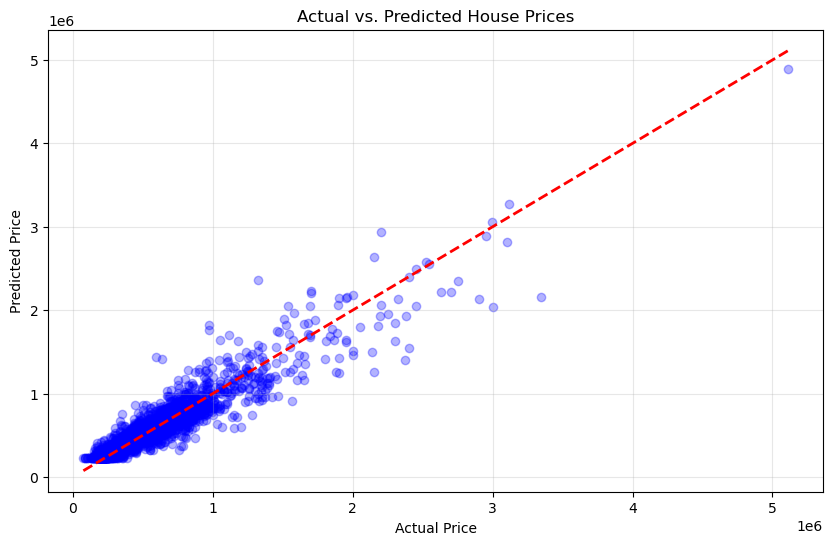

In [13]:
# --- BLOCK 6: MODEL EVALUATION ---
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score, mean_squared_error

print("Loading best performing model...")
# Load the model state with the lowest validation loss from training
best_model = load_model('best_hybrid_model.keras')

# 1. Generate Predictions
# Note: We use the validation generator to ensure data preprocessing matches training exactly
print("Generating predictions on validation set...")
val_predictions = best_model.predict(val_gen, verbose=1).flatten()

# 2. Align Ground Truth Data
# The generator processes data in full batches. We must align the actual labels 
# to match the number of predictions generated (dropping any final partial batch).
y_val_actual = val_gen.df[val_gen.y_col].values[:len(val_predictions)]

# 3. Calculate Metrics
r2 = r2_score(y_val_actual, val_predictions)
rmse = np.sqrt(mean_squared_error(y_val_actual, val_predictions))

print("\n--- FINAL HYBRID MODEL PERFORMANCE ---")
print(f"R² Score: {r2:.4f}")
print(f"RMSE:     {rmse:,.2f}")

# 4. Visualization: Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_val_actual, val_predictions, alpha=0.3, color='blue')
plt.plot([y_val_actual.min(), y_val_actual.max()], [y_val_actual.min(), y_val_actual.max()], 'r--', lw=2)
plt.title('Actual vs. Predicted House Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True, alpha=0.3)
plt.show()

Block 7: Predicts prices for the unknown submission dataset and saves the final_submission_hybrid.csv file (Generate Final Submission)

In [14]:
# --- BLOCK 7: GENERATE SUBMISSION FILE ---
filename = 'final_submission_hybrid.csv'

# Check if the file already exists
if os.path.exists(filename):
    print(f"Submission file '{filename}' already exists. Skipping prediction loop.")
    print("If you want to regenerate it, delete the file or rename it.")

else:
    print("Generating final submission predictions...")



    # 1. Feature Alignment
    train_features = [c for c in X_train.columns if c != 'price']
    X_submission_aligned = X_submission[train_features]

    # 2. Initialize Data Generator
    # We use batch_size=1 to ensure memory safety and that no rows are dropped.
    submission_gen = MultimodalDataGenerator(
        df=X_submission_aligned,
        x_col='id',
        y_col=None,
        image_dir=IMAGE_FOLDER,
        batch_size=1,        
        target_size=IMAGE_SIZE,
        shuffle=False  )     

    # 3. Prediction Loop
    # Iterate manually to predict one-by-one, avoiding RAM overload.
    all_predictions = []
    total_rows = len(submission_gen)

    for i in range(total_rows):
    # Fetch data batch (returns [image_data, tabular_data])
        batch_data = submission_gen[i]
    
        # Predict immediately (verbose=0 keeps output clean)
        pred = best_model.predict(batch_data, verbose=0).flatten()
        all_predictions.extend(pred)

    # 4. Create and Save Submission DataFrame
    submission_df = pd.DataFrame({
        'id': X_submission.index,
        'price': all_predictions
        })

    filename = 'final_submission_hybrid.csv'
    submission_df.to_csv(filename, index=False)

    print(f" Submission saved successfully: {filename}")
    print(f"Total Predictions: {len(submission_df)}")

Submission file 'final_submission_hybrid.csv' already exists. Skipping prediction loop.
If you want to regenerate it, delete the file or rename it.


Block 8: GRAD CAM EXPLAINABILITY

✅ Using 'X_test' for data lookup.

🔎 Explaining Random House ID: 1322049150


C:\Users\navya\AppData\Local\Temp\ipykernel_9324\1482618924.py:94: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


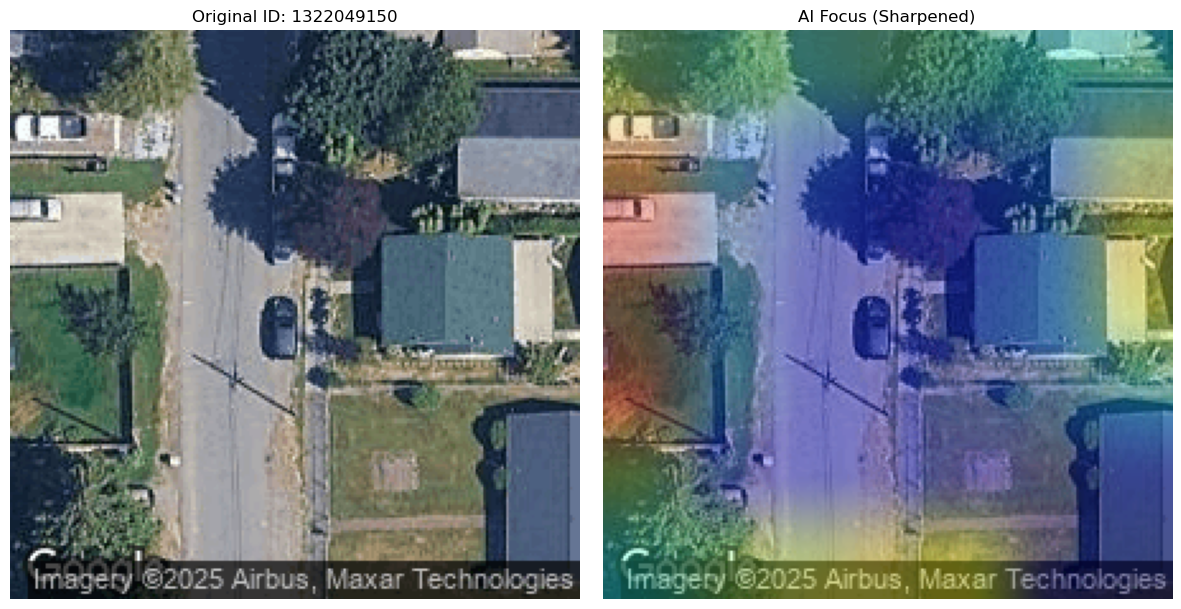

In [26]:
# --- BLOCK 8: GRAD-CAM VISUALIZATION (Corrected) ---
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 1. SETUP: Define Source Data
# Based on your repo, 'df_test' or 'X_test' contains the preprocessed features
# and the INDEX of this dataframe is the House ID.
try:
    if 'df_test' in locals():
        data_source = df_test
        print("✅ Using 'df_test' for data lookup.")
    elif 'X_test' in locals():
        data_source = X_test
        print("✅ Using 'X_test' for data lookup.")
    elif 'df' in locals():
        data_source = df
        print("✅ Using 'df' for data lookup.")
    else:
        raise ValueError("Could not find a dataframe (df_test, X_test, df). Please run preprocessing blocks first.")
except Exception as e:
    print(f"❌ Setup Error: {e}")

# 2. SELECT A RANDOM HOUSE
# We pick a random ID from the dataframe index to ensure it exists
try:
    random_idx = np.random.choice(data_source.index)
    target_id = str(random_idx) # Ensure ID is a string for file paths
    print(f"\n🔎 Explaining Random House ID: {target_id}")

    # 3. GET TABULAR DATA
    # We grab the specific row. If 'price' is in the columns, we drop it.
    feature_cols = [c for c in data_source.columns if c != 'price']
    
    # Get values and reshape to (1, N)
    tab_data = data_source.loc[random_idx, feature_cols].values.astype('float32')
    tab_in = np.expand_dims(tab_data, axis=0)

    # 4. GET IMAGE DATA
    # Based on your repo structure, images are in 'house_images/' with ID as filename
    img_path = os.path.join("house_images", f"{target_id}.jpg")
    
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image file not found: {img_path}")

    # Load & Preprocess
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_in = np.expand_dims(img_array / 255.0, axis=0) # Normalize 0-1

    # 5. GENERATE HEATMAP
    # Pass inputs to the explanation model you built earlier
    heatmap = make_gradcam_heatmap(img_in, tab_in, explanation_model)

    # --- CONTRAST FIX ---
    # Hybrid models often ignore images, causing "All Red" noise.
    # We apply a noise filter and contrast boost.
    if np.max(heatmap) < 1e-5:
        print("⚠️ Note: Model focus is purely tabular. Image influence is negligible.")
        heatmap = np.zeros_like(heatmap) # Clean blank map
    else:
        # Boost contrast to remove weak background noise
        heatmap = np.power(heatmap, 4) 
        if np.max(heatmap) > 0: heatmap /= np.max(heatmap)

    # 6. VISUALIZE
    original = img_in[0] * 255.0
    final = overlay_heatmap(heatmap, original)

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original.astype('uint8'))
    plt.title(f"Original ID: {target_id}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(final)
    plt.title("AI Focus (Sharpened)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"❌ Execution Error: {e}")
    print("Tip: Ensure 'house_images' folder is in the current directory.")

✅ Using Data Source with 3242 houses.

🔎 Analyzing House ID: 1338800280
📉 Image Contribution to Price: 0.0080%


C:\Users\navya\AppData\Local\Temp\ipykernel_9324\792161756.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")(np.arange(256))[:, :3]


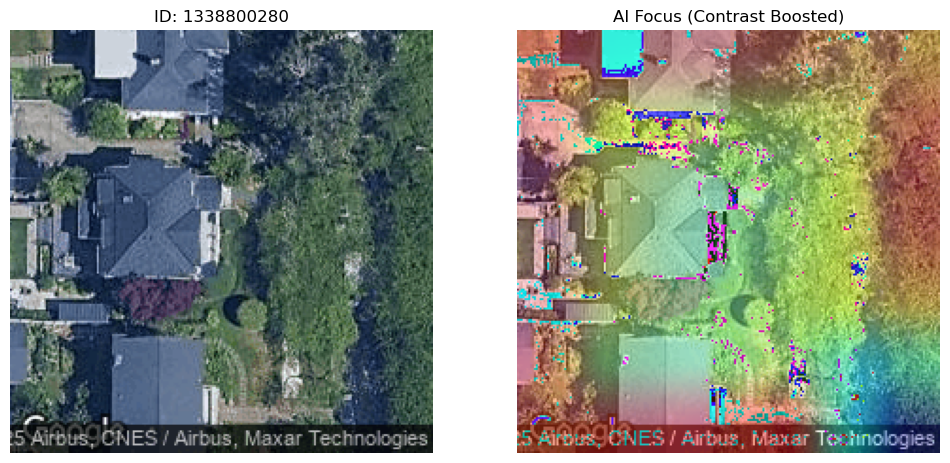

In [27]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, concatenate
from tensorflow.keras.applications import EfficientNetB0

# --- 1. CONFIGURATION ---
# Based on your repo, we look for the dataframe with IDs in the index
if 'X_test' in locals(): data_source = X_test
elif 'val_df' in locals(): data_source = val_df
elif 'X' in locals(): data_source = X
else: raise ValueError("❌ Dataframe not found. Please run preprocessing to load 'X' or 'X_test'.")

print(f"✅ Using Data Source with {len(data_source)} houses.")

# --- 2. REBUILD EXPLANATION MODEL ---
# We must rebuild the model to output the raw feature map AND the price
def build_explanation_model(tabular_shape):
    # Image Branch
    base_cnn = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    image_input = Input(shape=(224, 224, 3), name='image_input')
    # CRITICAL: We grab the raw features before pooling
    raw_features = base_cnn(image_input) 
    x_img = GlobalAveragePooling2D()(raw_features)
    
    # Tabular Branch
    tabular_input = Input(shape=(tabular_shape,), name='tabular_input')
    x_tab = Dense(64, activation='relu')(tabular_input)
    x_tab = Dense(32, activation='relu')(x_tab)
    
    # Combined
    combined = concatenate([x_img, x_tab])
    x = Dense(128, activation='relu')(combined)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='linear', name='price_output')(x)
    
    return Model(inputs=[image_input, tabular_input], outputs=[raw_features, output])

# Load Weights
explanation_model = build_explanation_model(tabular_shape=16)
# Ensure we load the weights from your trained file
explanation_model.load_weights('best_hybrid_model.keras')

# --- 3. THE BLINDFOLD TEST (Mathematical Proof) ---
def test_image_importance(img_in, tab_in):
    # Predict WITH image
    _, price_with_img = explanation_model.predict([img_in, tab_in], verbose=0)
    # Predict WITHOUT image (Black square)
    _, price_no_img = explanation_model.predict([np.zeros_like(img_in), tab_in], verbose=0)
    
    diff = np.abs(price_with_img[0][0] - price_no_img[0][0])
    impact_pct = (diff / price_with_img[0][0]) * 100
    return impact_pct

# --- 4. GRAD-CAM WITH CONTRAST BOOST ---
def make_heatmap(img_in, tab_in):
    with tf.GradientTape() as tape:
        img_tensor = tf.cast(img_in, tf.float32)
        tab_tensor = tf.cast(tab_in, tf.float32)
        conv_out, price = explanation_model([img_tensor, tab_tensor], training=False)
        if isinstance(price, list): price = price[0]
        
    grads = tape.gradient(price, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = conv_out[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    
    # NORMALIZATION & CONTRAST BOOST
    max_val = tf.math.reduce_max(heatmap)
    if max_val < 1e-5: return None # Signal is too weak (pure noise)
    
    heatmap /= max_val
    heatmap = tf.pow(heatmap, 4) # Power of 4 suppresses background noise
    return heatmap.numpy()

# --- 5. EXECUTION ---
# Pick a random house ID from the dataframe
random_id = np.random.choice(data_source.index)
print(f"\n🔎 Analyzing House ID: {random_id}")

# Load Tabular
# Assuming 16 features, we exclude the target if present
cols = [c for c in data_source.columns if c != 'price'] 
tab_data = data_source.loc[random_id, cols].values.astype('float32').reshape(1, -1)

# Load Image
img_path = os.path.join("house_images", f"{random_id}.jpg")
if os.path.exists(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_arr = img_to_array(img)
    img_in = np.expand_dims(img_arr / 255.0, axis=0)
    
    # A. Run Blindfold Test
    impact = test_image_importance(img_in, tab_data)
    print(f"📉 Image Contribution to Price: {impact:.4f}%")
    
    # B. Generate Heatmap
    heatmap = make_heatmap(img_in, tab_data)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1); plt.imshow(img_arr.astype('uint8')); plt.title(f"ID: {random_id}"); plt.axis('off')
    plt.subplot(1, 2, 2)
    
    if heatmap is None:
        plt.text(0.5, 0.5, "MODEL IGNORED IMAGE\n(100% Tabular Decision)", ha='center', fontsize=12)
        plt.title("No Visual Focus")
    else:
        # Overlay
        heatmap_uint8 = np.uint8(255 * heatmap)
        jet = cm.get_cmap("jet")(np.arange(256))[:, :3]
        jet_heatmap = jet[heatmap_uint8]
        jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap).resize((224, 224))
        final = np.array(jet_heatmap) * 0.4 + img_arr
        plt.imshow(final.astype('uint8'))
        plt.title("AI Focus (Contrast Boosted)")
        
    plt.axis('off')
    plt.show()

else:
    print(f"❌ Image {random_id}.jpg not found in 'house_images' folder.")